## 1. Postal codes of Toronto

In [1]:
import numpy as np
import pandas as pd

# web scrap
import requests
from bs4 import BeautifulSoup

# geocoding
import googlemaps

# show all columns
pd.set_option('display.max_columns', None)

In [2]:
# @hidden_cell
path = 'F:/gmaps_key.txt'
with open(path, 'r') as f:
    key = f.readline().replace('\n','')

#### Scrap wiki page

In [3]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

url_postal_codes = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req = requests.get(url_postal_codes, headers)
soup_wiki = BeautifulSoup(req.content, 'html.parser')

#### Fill dataframe

In [5]:
# create dataframe
df_postal_raw = pd.DataFrame(columns=['Postal Code', 'Borough', 'Neighbourhood'])
# table of postal codes
postal_table = soup_wiki.table
# all rows
postal_table_rows = postal_table.find_all('tr')
#print(len(postal_table_rows))
# get data for each row
for tr in postal_table_rows:
    # only search for data
    td = tr.find_all('td')
    # need to remove \n
    row = [i.text.replace('\n','') for i in td]
    # add to dataframe
    if len(row) == 3:
        row_series = pd.Series(row, index = df_postal_raw.columns)
        if row_series['Borough'] != 'Not assigned':
            if row_series['Neighbourhood'] == 'Not assigned':
                row_series['Neighbourhood'] = row_series['Borough']
            # append
            df_postal_raw = df_postal_raw.append(row_series, ignore_index = True)

In [14]:
df_postal_raw.head(15)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
df_postal_raw.shape

(103, 3)

There are 99 unique neighborhoods

In [ ]:
print(df_postal_raw['Neighbourhood'].unique().shape)
#df_postal_raw['Neighbourhood'].value_counts()

In [ ]:
#df_postal_raw[(df_postal_raw['Neighbourhood'] == 'Downsview') | (df_postal_raw['Neighbourhood'] == 'Don Mills')]

Remove duplicated neighbourhoods and check new dataframe size

In [ ]:
df_postal = df_postal_raw.drop_duplicates(subset=['Neighbourhood']).reset_index(drop=True)
#print(df_postal.shape)
#df_postal.head(15)

## 2. Get latitude and longitude coordinates of each neighbourhood

#### Use Google Maps Geocoding API to get coordinates
More reliable

In [15]:
# create gmap client
gmaps = googlemaps.Client(key=key)
# lists for coordinates
latitudes = []
longitudes = []
#
n_rows = df_postal.shape[0]
# loop over dataframe
for index, row in df_postal.iterrows():
    postal_code = row['Postal Code']
    address = '{}, Toronto, Ontario'.format(postal_code)
    # get geocode
    geocode_result = gmaps.geocode(address)
    lat = geocode_result[0]['geometry']['location']['lat']
    lng = geocode_result[0]['geometry']['location']['lng']
    # append to result
    latitudes.append(lat)
    longitudes.append(lng)
    print('{}/{} coordinates retrieved!'.format(index + 1, n_rows), end = '\r')
    
# add to dataframe
df_postal['Latitude'] = pd.Series(latitudes, index = df_postal.index)
df_postal['Longitude'] = pd.Series(longitudes, index = df_postal.index)

#df_postal.head()

In [17]:
df_postal.head(15)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## 3. Explore and cluster the neighborhoods in Toronto

### 3.1 Explore the neighborhoods in Toronto

In [18]:
# import libraries for visualization
import folium # map rendering library

#### Get coordinate of Toronto, ON, Canada

In [19]:
# Toronto longitude and latitude
address = 'Toronto, ON, Canada'
geocode_result = gmaps.geocode(address)
lat_toronto = geocode_result[0]['geometry']['location']['lat']
lng_toronto = geocode_result[0]['geometry']['location']['lng']

#### Create a map of Toronto with neighborhoods marked

In [1]:
map_toronto = folium.Map(location = [lat_toronto, lng_toronto], control_scale=True)
# add markers of neighborhood to map
for lat, lng, borough, neighborhood in zip(df_postal['Latitude'], df_postal['Longitude'], df_postal['Borough'], df_postal['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#1f5682',
        weight=1.5,
        fill=True,
        fill_color='#3395db',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

NameError: name 'folium' is not defined

#### Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = 'I4LBVKARVALYGZU3ZG23MGRTLVSJHTGJ1FOOTB3CHIQZTIK4' # your Foursquare ID
CLIENT_SECRET = 'UTRGZAVVPGRADQBFK3QFHF4PAIHUW0GUVR4CCJ4PR3TB0GLR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I4LBVKARVALYGZU3ZG23MGRTLVSJHTGJ1FOOTB3CHIQZTIK4
CLIENT_SECRET:UTRGZAVVPGRADQBFK3QFHF4PAIHUW0GUVR4CCJ4PR3TB0GLR


#### Define function to retrieve nearby venues of a neighborhood

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    no_venue_neighborhoods = []
    cnt = 0    
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        cnt += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if len(results) == 0:
            no_venue_neighborhoods.append(name)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print('Retrieved nearby venues of {}, {}/{} completed!                                                              '
                  .format(name, cnt, names.size), end='\r', flush=True)
        
    # report zero venue neighborhoods
    print('\nThe following neighborhoods has 0 venue within the radius of {} m'.format(radius))
    for z_neighbor in no_venue_neighborhoods:
        print(z_neighbor)
    
    # assemble dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get nearby venues of each neighborhood
Note that a radius of 1000m is used

In [47]:
toronto_venues = getNearbyVenues(names=df_postal['Neighbourhood'],
                                   latitudes=df_postal['Latitude'],
                                   longitudes=df_postal['Longitude'],
                                   radius=1000 )


Retrieved nearby venues of Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West, 99/99 completed!                                                                                                      
The following neighborhoods has 0 venue within the radius of 1000 m


#### Check the size of resulting dataframe

In [48]:
# check the size of resulting dataframe
print(toronto_venues.shape)
toronto_venues.head()

(4875, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store


#### Check how many venues were returned for each neighborhood

In [49]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,55,55,55,55,55,55
"Alderwood, Long Branch",26,26,26,26,26,26
"Bathurst Manor, Wilson Heights, Downsview North",30,30,30,30,30,30
Bayview Village,16,16,16,16,16,16
"Bedford Park, Lawrence Manor East",40,40,40,40,40,40
...,...,...,...,...,...,...
"Willowdale, Willowdale West",11,11,11,11,11,11
Woburn,9,9,9,9,9,9
Woodbine Heights,30,30,30,30,30,30


#### Check how many unique venue categories

In [50]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 334 uniques categories.


#### Some neighborhoods are found as venues, so we need to drop them

In [51]:
toronto_venues[toronto_venues['Venue Category']=='Neighborhood']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
416,"Garden District, Ryerson",43.657162,-79.378937,Downtown Toronto,43.653232,-79.385296,Neighborhood
649,St. James Town,43.651494,-79.375418,Downtown Toronto,43.653232,-79.385296,Neighborhood
792,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
876,Berczy Park,43.644771,-79.373306,Harbourfront,43.639526,-79.380688,Neighborhood
1014,Central Bay Street,43.657952,-79.387383,Downtown Toronto,43.653232,-79.385296,Neighborhood
1341,"Richmond, Adelaide, King",43.650571,-79.384568,Downtown Toronto,43.653232,-79.385296,Neighborhood
1690,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Harbourfront,43.639526,-79.380688,Neighborhood
2135,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Downtown Toronto,43.653232,-79.385296,Neighborhood
2214,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,Parkdale,43.640524,-79.432200,Neighborhood
2442,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Downtown Toronto,43.653232,-79.385296,Neighborhood


In [55]:
# drop neighborhood venues
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.shape

There are 333 uniques categories.


(4861, 7)

#### Analyze Neighborhoods

In [56]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack 

New dataframe size

In [57]:
toronto_onehot.shape

(4861, 334)

#### Group rows by neighborhood and take the mean of the occurance of each category

In [58]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack 

Check new dataframe size

In [71]:
toronto_grouped.shape

(99, 334)

#### Get top 10 most common venues for each neighborhood

Function to sort the venues in decending orders

In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a dataframe and display top 10 venues for each neighborhood

In [81]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']        

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Caribbean Restaurant,Coffee Shop,Sandwich Place,Indian Restaurant,Bakery,Skating Rink,Bar,Noodle House
1,"Alderwood, Long Branch",Discount Store,Convenience Store,Park,Pizza Place,Pharmacy,Print Shop,Trail,Shopping Mall,Garden Center,Gas Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Bank,Coffee Shop,Sandwich Place,Supermarket,Frozen Yogurt Shop,Chinese Restaurant,Gas Station,Fried Chicken Joint,Shopping Mall
3,Bayview Village,Gas Station,Bank,Grocery Store,Japanese Restaurant,Playground,Park,Restaurant,Café,Skate Park,Skating Rink
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Pizza Place,Sandwich Place,Bank,Restaurant,Bagel Shop,Thai Restaurant,Bakery,Comfort Food Restaurant
5,Berczy Park,Coffee Shop,Café,Japanese Restaurant,Hotel,Park,Restaurant,Beer Bar,Seafood Restaurant,Bakery,Cocktail Bar
6,"Birch Cliff, Cliffside West",Park,Convenience Store,Diner,Café,Skating Rink,General Entertainment,Gym,Gym Pool,Auto Workshop,College Stadium
7,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bar,Furniture / Home Store,Bakery,Restaurant,Tibetan Restaurant,Gift Shop,Arts & Crafts Store,Performing Arts Venue
8,"Business reply mail Processing Centre, South C...",Park,Coffee Shop,Pizza Place,Brewery,Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Bakery,Electronics Store,Farmers Market
9,"CN Tower, King and Spadina, Railway Lands, Har...",Café,Coffee Shop,Harbor / Marina,Sculpture Garden,Scenic Lookout,Track,Dog Run,Garden,Park,Airport


### 3.2 Cluster Neighborhoods

In [87]:
# import libraries
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [83]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 0, 0, 4, 0, 0, 0])

Create a new dataframe including the cluster and top 10 venues for each neighborhood

In [84]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_postal

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4,Park,Convenience Store,Bus Stop,Pharmacy,Shopping Mall,Laundry Service,Discount Store,Skating Rink,Coffee Shop,Grocery Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Coffee Shop,French Restaurant,Intersection,Gym / Fitness Center,Boxing Gym,Golf Course,Café,Pizza Place,Men's Store,Playground
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Café,Park,Theater,Breakfast Spot,Restaurant,Bakery,Diner,Brewery
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Fast Food Restaurant,Coffee Shop,Vietnamese Restaurant,Restaurant,Furniture / Home Store,Fried Chicken Joint,Dessert Shop,Sushi Restaurant,Sandwich Place
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Café,Sushi Restaurant,Park,Italian Restaurant,Ramen Restaurant,Thai Restaurant,Gastropub,Pizza Place,Japanese Restaurant
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,4,Park,Pharmacy,Bank,Golf Course,Bakery,Shopping Mall,Grocery Store,Skating Rink,Baseball Field,Convenience Store
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Coffee Shop,Trail,Bank,Paper / Office Supplies Store,Bakery,Park,Gym,Caribbean Restaurant,Supermarket
7,M3B,North York,Don Mills,43.745906,-79.352188,0,Coffee Shop,Japanese Restaurant,Pizza Place,Burger Joint,Café,Tennis Court,Bar,Liquor Store,Supermarket,Breakfast Spot
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,Coffee Shop,Pizza Place,Construction & Landscaping,Gym / Fitness Center,Brewery,Bus Line,Road,Gastropub,Bank,Bakery
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Gastropub,Restaurant,Hotel,Japanese Restaurant,Italian Restaurant,Diner,Seafood Restaurant,Creperie,Department Store


Visualize resulting cluster

In [100]:
map_toronto_clusters = folium.Map(location = [lat_toronto, lng_toronto], control_scale=True, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cm.get_cmap('tab10').colors
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        weight=1.5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_toronto_clusters)
       
map_toronto_clusters

#### In case the map did not load, here's a screenshot of clustering result
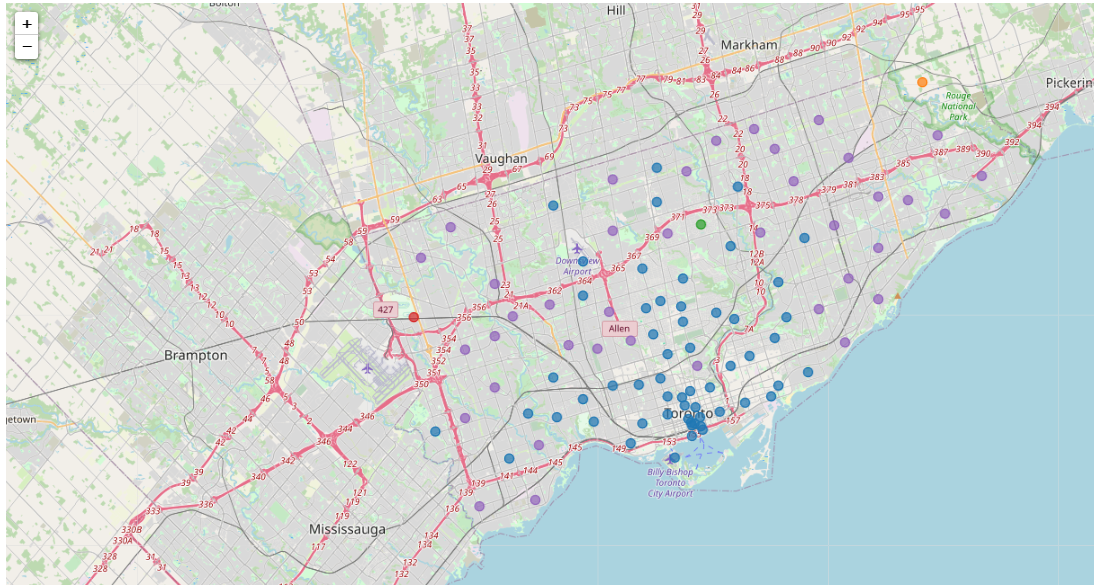